# 1. Resources

In [1]:
# Essentials
import pickle
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold

# PyTorch
import torch
import torchvision
import torch.nn as nn  
import torch.nn.functional as F  
import torchvision.datasets as datasets  
import torchvision.transforms as transforms  
from torch.utils.data import DataLoader

In [2]:
torch.__version__

'1.9.0'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Variables and Function define

In [ ]:
# Imagenet normalization
in_mean = [0.485, 0.456, 0.406]
in_std = [0.229, 0.224, 0.225]

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),  
        transforms.RandomHorizontalFlip(),  # augmentations
        transforms.ToTensor(),
        transforms.Normalize(mean, std)  
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
# Function for import data
def data_preprocess_kfold_group_stratify(meta_path, classify, brand, location, fold_chosen, split=5):
    path_bag_loc_df = pd.read_csv(meta_path + 'imagepaths.csv')
    path_bag_df = path_bag_loc_df[path_bag_loc_df.location == location].drop("location", axis=1)
    bag_classify_df = pd.read_csv(meta_path + f'bags{brand}.csv')[['bag', classify]]
    path_bag_classify_df = path_bag_df.merge(bag_classify_df, how='left', on='bag').replace(r'^\s*$', np.NaN, regex=True).dropna(axis=0)
    # Stratified Group K-fold
    path_bag_classify_df['fold'] = -1
    sgkf = StratifiedGroupKFold(n_splits=split)
    for fold, (train_idxs, test_idxs) in enumerate(sgkf.split(X=path_bag_classify_df['path'].values, 
                                                              y=path_bag_classify_df[classify].values, 
                                                              groups=path_bag_classify_df['bag'])):
        path_bag_classify_df.iloc[test_idxs, 3] = fold
    path_classify_df = path_bag_classify_df.drop("bag", axis= 1)
    train_df = path_classify_df[path_classify_df.fold != fold_chosen].drop("fold", axis=1)
    val_df = path_classify_df[path_classify_df.fold == fold_chosen].drop("fold", axis=1)
    labels = np.intersect1d(train_df[classify].unique(), val_df[classify].unique())
    train_df2 = train_df[train_df[classify].isin(labels)]
    val_df2 = val_df[val_df[classify].isin(labels)]
    print(f"Take {fold_chosen}th fold for validation")
    print(f"Train: {len(train_df)} samples, {len(train_df[classify].unique())} classes.")
    print(f"Validation: {len(val_df)} samples, {len(val_df[classify].unique())} classes.")
    print(f"Use intersecting label with {len(labels)} classes.")
    print(f"Using {round(train_df[classify].isin(labels).value_counts(normalize=True)[1], 4) * 100}% samples in train dataset.")
    print(f"Using {round(val_df[classify].isin(labels).value_counts(normalize=True)[1], 4) * 100}% samples in validation dataset.")
    return train_df2, val_df2, labels

In [ ]:
# Function for lower triangle confusion matrix
def tril_confusion_matrix(y_true, y_pred, normalize = None, tril=True):
    """Create a lower triangle confusion matrix

    Args:
        y_true (NumpyArray): true labels
        y_pred (NumpyArray): prediction labels
        normalize ("true", "pred", "all", None optional): Choose whether normalize or not. Defaults to None.
    """
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    # Create an mask for triangle
    mask = np.ones_like(cm, dtype=np.bool)
    mask[np.tril_indices_from(mask)] = False

    # Plot confusion matrix in a beautiful manner
    sns.set_style()
    fig = plt.figure(figsize=(16, 14))
    ax = plt.subplot()

    if tril == True:
        sns.heatmap(cm, ax=ax, mask=mask, cmap="Blues", square=True, linewidths=.5)
    else:
        sns.heatmap(cm, ax=ax, cmap="Blues", square=True, linewidths=.5)

    ax.set_xlabel('Predicted Label', fontsize=20)
    ax.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)
    plt.title('Lower Triangle Confusion Matrix', fontsize=20)
    # plt.savefig('ConfusionMat.png')
    plt.show()

In [ ]:
# Function for find the worst error
def find_the_worst_error(prob, y_pred, y_true, label_names, data_ds, batch_size):
    """Input numpy array with probability, prediction labels, true labels, dataset, batch size.
    Which return the worst prediction picture, predict and label

    Args:
        prob (ndarray): probability after prediction
        y_pred (numpy.array): prediction label of dataset
        y_true (numpy.array): true label of dataset
        data_ds (tf.dataset): dataset
        batch_size (int): batch size of dataset
        label_names (list): list of labels class name

    Returns:
        _type_: _description_
    """
    
    # Find index
    mask = y_pred != y_true
    subset_idx = np.argmax(prob[mask]) // len(label_names)      # find the max probability with mask
    parent_idx = np.arange(prob.shape[0])[mask][subset_idx]     # find index in parent dataset
    batch_idx = parent_idx // batch_size                        # find batch
    idx = parent_idx % batch_size                               # find index in batch
    
    # Variable return
    label = label_names[y_true[parent_idx]]                     # label of the worst error
    worst_prob = max(prob[mask].flatten())
    predict = label_names[y_pred[parent_idx]]                   # prediction of the worst error
    batch = list(data_ds.skip(batch_idx).take(1))[0][0].numpy() # remove the label
    picture = batch[idx]
    
    # Print result
    plt.imshow(picture.astype(np.uint8))
    plt.axis("off")
    print(f"The prediction label is: {predict}")
    print(f"The true label is: {label}")
    print(f"The probability is {worst_prob * 100}%")

In [ ]:
# Function return N top error
def top_n_error(prob, y_pred, y_true, labels, data_ds, batch_size, n_top):
    mask = y_pred != y_true
    error_df = prob[mask]
    flat_indices = np.argpartition(error_df.ravel(), -n_top)[-n_top:]
    error_indices, label_indices = np.unravel_index(flat_indices, error_df.shape)
    img_indices = np.arange(prob.shape[0])[mask][error_indices]
    batch_indices = img_indices % batch_size
    idx = img_indices % batch_size
            
    # Variable return
    prob_list = []
    picture_list = []
    for i in range(n_top):
        prob_list.append(error_df[error_indices[i], label_indices[i]])
        batch = list(data_ds.skip(batch_indices[i]).take(1))[0][0].numpy()
        picture_list.append(batch[idx[i]])
    label_list = y_true[img_indices]
    predict_list = y_pred[img_indices]

    # Print result
    width = 5
    height = int(np.ceil(n_top / width))
    plt.figure(figsize=(20, 5 * height))
    for i in range(n_top):
        picture = picture_list[i]
        plt.subplot(height, width, i + 1)
        plt.imshow(picture.astype(np.uint8))
        plt.title(f"True: {labels[label_list[i]]} \n Predict: {labels[predict_list[i]]} \n {round(prob_list[i], 2) * 100}%")
        plt.axis("off")

In [ ]:
# Visualization for class compare
def class_sample_comparision(val_df, train_df, classify, labels, numlist):
    label1 = labels[numlist[0]]
    label2 = labels[numlist[1]]
    path_list_1 = list(val_df[val_df[classify] == label1].drop(classify, axis=1)["path"])
    path_list_2 = list(val_df[val_df[classify] == label2].drop(classify, axis=1)["path"])
    path_list_3 = list(train_df[train_df[classify] == label1].drop(classify, axis=1)["path"])
    path_list_4 = list(train_df[train_df[classify] == label2].drop(classify, axis=1)["path"])

    plt.figure(figsize=(20, 14))
    for i in range(5):
        path = random.choice(path_list_1)
        ax = plt.subplot(4, 5, i + 1)
        img = cv2.imread(path)[..., ::-1]
        plt.imshow(img)
        plt.title(f"Validation-{label1}")
        plt.axis("off")
    for i in range(5):
        path = random.choice(path_list_2)
        ax = plt.subplot(4, 5, i + 6)
        img = cv2.imread(path)[..., ::-1]
        plt.imshow(img)
        plt.title(f"Validation-{label2}")
        plt.axis("off")
    for i in range(5):
        path = random.choice(path_list_3)
        ax = plt.subplot(4, 5, i + 11)
        img = cv2.imread(path)[..., ::-1]
        plt.imshow(img)
        plt.title(f"Train-{label1}")
        plt.axis("off")
    for i in range(5):
        path = random.choice(path_list_4)
        ax = plt.subplot(4, 5, i + 16)
        img = cv2.imread(path)[..., ::-1]
        plt.imshow(img)
        plt.title(f"Train-{label2}")
        plt.axis("off")

## 1.1. Meta data

In [ ]:
fold_chosen = 2
classify = "mat"
brand = "gucci"
location = 1
meta_path = "/storage/experiments/gucci-202202211437/csv/"

In [ ]:
train_df, val_df, labels = data_preprocess_kfold_group_stratify(meta_path, classify, brand, location, fold_chosen)

In [ ]:
train_df = train_df[train_df[classify].isin(labels)]
val_df = val_df[val_df[classify].isin(labels)]

In [ ]:
# Take a quick look at class distribution
label_df = val_df["mat"]
freq = label_df.value_counts(normalize=True)
freq = round(freq, 4) * 100     # convert to percentage
print(freq)    

leather                30.70
gg supreme canvas      19.39
canvas                 17.74
ggcanvas                9.36
coatedcanvas            4.71
guccissima              4.23
microguccissima         1.74
nylon                   1.28
suede                   1.27
flora canvas            1.22
guccissima nylon        1.04
gg plus                 1.04
python                  0.82
gg imprime              0.66
calf                    0.65
enamel                  0.59
denim                   0.49
velvet                  0.40
gg embossed leather     0.28
gg nylon                0.24
gg crystal              0.23
linen                   0.21
jacquard                0.15
ostrich                 0.15
crocodile               0.14
lizard                  0.13
quilted leather         0.11
leather+canvas          0.10
canvas+leather          0.10
wool                    0.10
velor                   0.07
pig                     0.07
nubuck                  0.06
fur                     0.06
suede+leather 

## 1.2 Dataset, DataLoader

In [ ]:
# Directories
data_dir = "/storage/intern"
label_path = "./mat/MatLB3"
params_path = "./model/model_params"
experiment = "mat"
# Define parameter
batch_size = 64
num_workers = 2

In [ ]:
# Dataset
train_set = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
val_set = datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"])
# Loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Dataset characteristic

In [ ]:
train_size = len(train_set)
val_size = len(val_set)
num_batches = math.floor(train_size/batch_size)
print(f"Train dataset: {train_size}")
print(f"Val dataset: {val_size}")
print(f"Number of batches: {num_batches}")

In [ ]:
# Labels
label_names = pickle.loads(open(label_path, "rb").read())
print(len(label_names))

## 1.3. Model

In [ ]:
# Model
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)
in_fc = model.classifier.fc.in_features
model.classifier.fc = nn.Linear(in_fc, num_class)
# Load params
model.load_state_dict(torch.load(params_path))
model.eval()
# Labels
label_names = pickle.loads(open(label_path, "rb").read())
print(len(label_names))

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"


31


# 2. Classes

In [10]:
# Pick top-20 classes for visualization
val_freq = pd.DataFrame(round(val_df[classify].value_counts(normalize=True), 4) * 100)[:20]
train_freq = pd.DataFrame(round(train_df[classify].value_counts(normalize=True), 4) * 100)[:20]

<Figure size 1152x1008 with 0 Axes>

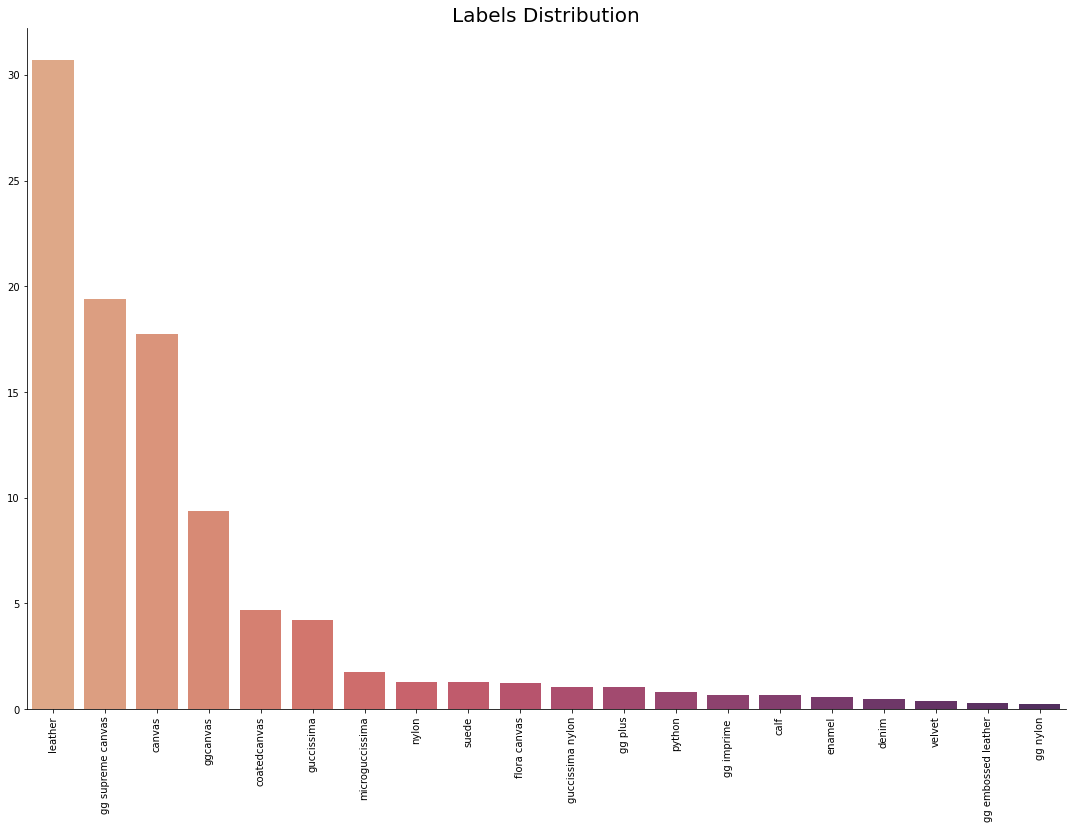

In [11]:
sns.set_style("white")
flatui = ["#95a5a6", "#34495e"]
# Validation
sns.catplot(data=val_freq.transpose(), kind="bar", height=10, aspect=1.5, legend_out=True, palette=flatui)
plt.xticks(rotation=90)
plt.title('Validation Distribution', fontsize=20)  
#Train
sns.catplot(data=train_freq.transpose(), kind="bar", height=10, aspect=1.5, legend_out=True, palette=flatui)
plt.xticks(rotation=90)
plt.title('Train Distribution', fontsize=20)  
# plt.show()

# 3. Model evaluation

## For first time

In [19]:
model.eval()
model.to(device)
prob = []   # probability
y_pred = [] # prediction labels
y_true = [] # tru labels
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        labels = labels.to(device)
        images = images.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        labels = labels.detach().cpu().numpy()
        outputs = outputs.detach().cpu().numpy()
        predicted = predicted.detach().cpu().numpy()
        prob.append(outputs)
        y_pred.append(predicted)
        y_true.append(labels)

prob = np.concatenate(prob)        
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

In [39]:
pred_path = "./mat/pred"
true_path = "./mat/true"
prob_path = "./mat/prob"

In [40]:
# Pickle label and prediction
f = open(pred_path, "wb")
f.write(pickle.dumps(y_pred))
f.close()

f = open(true_path, "wb")
f.write(pickle.dumps(y_true))
f.close()

f = open(prob_path, "wb")
f.write(pickle.dumps(prob))
f.close()

## Reimport probability, predict and true labels

In [9]:
# y_pred = pickle.loads(open(pred_path, "rb").read())
# y_true = pickle.loads(open(true_path, "rb").read())
# prob = pickle.loads(open(prob_path, "rb").read())

## Confusion matrix:

Confusion matrix without Normalized

In [ ]:
tril_confusion_matrix(y_true, y_pred)

Confusion Matrix with Normalized

In [ ]:
tril_confusion_matrix(y_true, y_pred, normalize="true", tril=False)

Visualize error

In [ ]:
a = [4, 16, 20]
for num in a:
    print(labels[num])

In [ ]:
# Confusion dictionary for > 0.6 confusion rate
cm = confusion_matrix(y_true, y_pred, normalize="true")
np.fill_diagonal(cm, 0)
label_idx, pred_idx = np.where(cm > 0.6)
confusion_dict = {}
for i in range(len(label_idx)):
    high_rate = [label_idx[i], pred_idx[i]]
    confusion_dict[f"high_{i + 1}"] = high_rate
    print(high_rate)

In [ ]:
for i in (confusion_dict):
    class_sample_comparision(val_df, train_df, classify, labels, confusion_dict[i])

In [ ]:
find_the_worst_error(prob=prob, 
                     y_pred=y_pred, 
                     y_true=y_true, 
                     label_names=labels, 
                     data_ds=val_ds, 
                     batch_size=batch_size)

In [ ]:
top_n_error(prob, y_pred, y_true, labels, val_ds, batch_size, 14)